#### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/IASNLP"

/content/drive/MyDrive/IASNLP


# Importing Necessary Libraries

In [3]:
!pip install sentencepiece
!pip install sacrebleu
!pip install tensorflow-gpu # ---> For GPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.9 kB/s 
     |████████████████████████████████| 5.8 MB 52.8 MB/s 
     |████████████████████████████████| 438 kB 67.1 MB/s 
     |████████████████████████████████| 1.6 MB 58.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninsta

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda, Layer, Embedding, LayerNormalization
import sentencepiece as spm
from sacrebleu.metrics import BLEU, CHRF, TER

import matplotlib.pyplot as plt

from collections import Counter

# Loading Data

We load the `train_data`, `train_dev_data`, `test_val_data` and `test_data` as well as the byte-pair encoder tokenizer for English and Bengali i.e. `sp_en_bpe` and `s_ben_bpe`.

In [5]:
train_data, train_dev_data = pd.read_csv("train_data.csv")[['src', 'tgt']], pd.read_csv("train_dev.csv")[['src', 'tgt']] 
test_val_data, test_data = pd.read_csv("test_val.csv")[['src', 'tgt']], pd.read_csv("test_data.csv")[['src', 'tgt']]
sp_en_bpe, sp_ben_bpe = spm.SentencePieceProcessor(), spm.SentencePieceProcessor()
sp_en_bpe.load('eng_bpe.model'); sp_ben_bpe.load('ben_bpe.model');

# Data Preprocessing

We decide on some formats of the data and batches. We take the maximum tokens we can have per tokenized English and Bengali sentence to be `MAX_TOKENS = 60`. We use the vocabulary size of `32000`(i.e. `ENCODER_VOCAB = DECODER_VOCAB = 32000`). A batch size of `256` was choosen for our Mini-Batch Gradient Descent which is used to train our Model.

In [6]:
MAX_TOKENS = 60
VOCAB_SIZE = 32000
BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE*4

The following two functions help in tokenizing an detokenizing the data based on our sentencepiece byte-pair encoding model.

In [7]:
def tokenize(sentence, sp_model, add_bos = True, add_eos = True):
    bos = [sp_model.bos_id()] if add_bos else []
    eos = [sp_model.eos_id()] if add_eos else []
    inputs = bos + sp_model.encode_as_ids(sentence) + eos
    return np.reshape(np.array(inputs), [1, -1])
def detokenize(tokenized, sp_model, is_bos = True, is_eos = True):
    integers = np.squeeze(tokenized).tolist()
    if is_eos:
        return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.eos_id())])
    else:
        if sp_model.pad_id() in tokenized:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.pad_id())])
        else:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):])

We have tokenized the data.

In [8]:
# Tokenization
src_train_data_enc = [np.squeeze(tokenize(train_data['src'].iloc[i], sp_en_bpe)) for i in range(train_data.shape[0])]
tgt_train_data_enc = [np.squeeze(tokenize(train_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_data.shape[0])]
src_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['src'].iloc[i], sp_en_bpe)) for i in range(train_dev_data.shape[0])]
tgt_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_dev_data.shape[0])]
src_test_val_data_enc = [np.squeeze(tokenize(test_val_data['src'].iloc[i], sp_en_bpe)) for i in range(test_val_data.shape[0])]
tgt_test_val_data_enc = [np.squeeze(tokenize(test_val_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(test_val_data.shape[0])]

We have padded the data with post-truncation and post padding upto MAX_TOKENS number of tokens.

In [9]:
# Padding
# The reason why we add MAX_TOKENS+1 after-pad length for Bengali is that when we form the tf.Dataset later, we will shift the target sentence once and will truncate the last token once
# Hence, it will get adjusted
train_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_src = tf.keras.preprocessing.sequence.pad_sequences(src_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')

Below, we discard all those pairs where the tokenized source or target sentences are larger than MAX_TOKENS number of tokens.

In [10]:
# Removing all pairs whose either the target sentence or source setence exceeds MAX_TOKENS number of tokens
same_idx = list(set([i for i in range(train_src.shape[0]) if train_src[i][-1] == 1 or train_src[i][-1] == 0]).intersection(set([i for i in range(train_tgt.shape[0]) if train_tgt[i][-1] == 1 or train_tgt[i][-1] == 0])))
train_src = train_src[same_idx]
train_tgt = train_tgt[same_idx]
same_idx = list(set([i for i in range(train_dev_src.shape[0]) if train_dev_src[i][-1] == 1 or train_dev_src[i][-1] == 0]).intersection(set([i for i in range(train_dev_tgt.shape[0]) if train_dev_tgt[i][-1] == 1 or train_dev_tgt[i][-1] == 0])))
train_dev_src = train_dev_src[same_idx]
train_dev_tgt = train_dev_tgt[same_idx]
same_idx = list(set([i for i in range(test_val_src.shape[0]) if test_val_src[i][-1] == 1 or test_val_src[i][-1] == 0]).intersection(set([i for i in range(test_val_tgt.shape[0]) if test_val_tgt[i][-1] == 1 or test_val_tgt[i][-1] == 0])))
test_val_src = test_val_src[same_idx]
test_val_tgt = test_val_tgt[same_idx]

In [11]:
train_labels = np.zeros(train_tgt.shape)
train_labels[:,0:train_tgt.shape[1] -1] = train_tgt[:,1:]
train_dev_labels = np.zeros(train_dev_tgt.shape)
train_dev_labels[:,0:train_dev_tgt.shape[1] -1] = train_dev_tgt[:,1:]
test_val_labels = np.zeros(test_val_tgt.shape)
test_val_labels[:,0:test_val_tgt.shape[1] -1] = test_val_tgt[:,1:]

In [12]:
print("*** Preprocessed Data ***")
print("Train Data Shape(Source): ", train_src.shape)
print("Train Data Shape(Target): ", train_tgt.shape)
print("Train Labels Shape(Target): ", train_labels.shape)
print("Train Dev Data Shape(Source): ", train_dev_src.shape)
print("Train Dev Data Shape(Target): ", train_dev_tgt.shape)
print("Train Dev Labels Shape(Target): ", train_dev_labels.shape)
print("Test Val Data Shape(Source): ", test_val_src.shape)
print("Test Val Data Shape(Target): ", test_val_tgt.shape)
print("Test Labels Shape(Target): ", test_val_labels.shape)

*** Preprocessed Data ***
Train Data Shape(Source):  (154836, 60)
Train Data Shape(Target):  (154836, 60)
Train Labels Shape(Target):  (154836, 60)
Train Dev Data Shape(Source):  (3649, 60)
Train Dev Data Shape(Target):  (3649, 60)
Train Dev Labels Shape(Target):  (3649, 60)
Test Val Data Shape(Source):  (1194, 60)
Test Val Data Shape(Target):  (1194, 60)
Test Labels Shape(Target):  (1194, 60)


Below we prepare the data in the form ready to feed to the Model.

In [13]:
train_data_prep = tf.data.Dataset.from_tensor_slices((train_src, train_tgt, train_labels))
train_dev_data_prep = tf.data.Dataset.from_tensor_slices((train_dev_src, train_dev_tgt, train_dev_labels))
test_val_data_prep = tf.data.Dataset.from_tensor_slices((test_val_src, test_val_tgt, test_val_labels))

Below, we can see how our data looks

In [14]:
for encoder_inputs, decoder_inputs, labels in train_data_prep.take(1):
    print(f'encoder_inputs.shape: {encoder_inputs.shape}')
    print(f'decoder_inputs.shape: {decoder_inputs.shape}')
    print(f"labels.shape: {labels.shape}")

encoder_inputs.shape: (60,)
decoder_inputs.shape: (60,)
labels.shape: (60,)


# Model

We will use the Transformer Architechture with the following hyperparameters.

In [15]:
# Transformer parameters
d_model = 512 # 512 in the original paper
d_k = 64 # 64 in the original paper
d_v = 64 # 64 in the original paper
n_heads = 8 # 8 in the original paper
n_encoder_layers = 2 # 6 in the original paper
n_decoder_layers = 2 # 6 in the original paper

max_token_length = MAX_TOKENS # 512 in the original paper

In [16]:
class SingleHeadAttention(Layer):
  def __init__(self, input_shape=(3, -1, d_model), dropout=.0, masked=None):
    super(SingleHeadAttention, self).__init__()
    self.q = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.normalize_q = Lambda(lambda x: x / np.sqrt(d_k))
    self.k = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.v = Dense(d_v, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.dropout = dropout
    self.masked = masked
  
  # Inputs: [query, key, value]
  def call(self, inputs, training=None):
    assert len(inputs) == 3
    # We use a lambda layer to divide vector q by sqrt(d_k) according to the equation
    q = self.normalize_q(self.q(inputs[0]))
    k = self.k(inputs[1])
    # The dimensionality of q is (batch_size, query_length, d_k) and that of k is (batch_size, key_length, d_k)
    # So we will do a matrix multication by batch after transposing last 2 dimensions of k
    # tf.shape(attn_weights) = (batch_size, query_length, key_length)
    attn_weights = tf.matmul(q, tf.transpose(k, perm=[0,2,1]))
    if self.masked: # Prevent future attentions in decoding self-attention
      # Create a matrix where the strict upper triangle (not including main diagonal) is filled with -inf and 0 elsewhere
      length = tf.shape(attn_weights)[-1]
      #attn_mask = np.triu(tf.fill((length, length), -np.inf), k=1) # We need to use tensorflow functions instead of numpy
      attn_mask = tf.fill((length, length), -np.inf)
      attn_mask = tf.linalg.band_part(attn_mask, 0, -1) # Get upper triangle
      attn_mask = tf.linalg.set_diag(attn_mask, tf.zeros((length))) # Set diagonal to zeros to avoid operations with infinity
      # This matrix is added to the attention weights so all future attention will have -inf logits (0 after softmax)
      attn_weights += attn_mask
    # Softmax along the last dimension
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    if training: # Attention dropout included in the original paper. This is possibly to encourage multihead diversity.
      attn_weights = tf.nn.dropout(attn_weights, rate=self.dropout)
    v = self.v(inputs[2])
    return tf.matmul(attn_weights, v)

class MultiHeadAttention_my(Layer):
  def __init__(self, dropout=.0, masked=None):
    super(MultiHeadAttention_my, self).__init__()
    self.attn_heads = list()
    for i in range(n_heads): 
      self.attn_heads.append(SingleHeadAttention(dropout=dropout, masked=masked))
    self.linear = Dense(d_model, input_shape=(-1, n_heads * d_v), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    
  def call(self, x, training=None):
    attentions = [self.attn_heads[i](x, training=training) for i in range(n_heads)]
    concatenated_attentions = tf.concat(attentions, axis=-1)
    return self.linear(concatenated_attentions)

class TransformerEncoder(Layer):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerEncoder, self).build(input_shape)
  def call(self, x, training=None):
    sublayer1 = self.multihead_attention((x, x, x), training=training)
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.linear2(self.linear1(layernorm1))
    sublayer1 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    return layernorm2
  def compute_output_shape(self, input_shape):
    return input_shape

class TransformerDecoder(Layer):
  def __init__(self, dropout=.0, attention_dropout=.0, **kwargs):
    super(TransformerDecoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_self_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate, masked=True)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.multihead_encoder_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout3 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization3 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerDecoder, self).build(input_shape)
  def call(self, x, hidden, training=None):
    sublayer1 = self.multihead_self_attention((x, x, x))
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.multihead_encoder_attention((x, hidden, hidden))
    sublayer2 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    
    sublayer3 = self.linear2(self.linear1(layernorm1))
    sublayer3 = self.dropout3(sublayer3, training=training)
    layernorm3 = self.layer_normalization2(layernorm2 + sublayer3)
    return layernorm3
  def compute_output_shape(self, input_shape):
    return input_shape

class SinusoidalPositionalEncoding(Layer): # This is a TensorFlow implementation of https://github.com/graykode/nlp-tutorial/blob/master/5-1.Transformer/Transformer_Torch.ipynb
  def __init__(self):
    super(SinusoidalPositionalEncoding, self).__init__()
    self.sinusoidal_encoding = np.array([self.get_positional_angle(pos) for pos in range(max_token_length)], dtype=np.float32)
    self.sinusoidal_encoding[:, 0::2] = np.sin(self.sinusoidal_encoding[:, 0::2])
    self.sinusoidal_encoding[:, 1::2] = np.cos(self.sinusoidal_encoding[:, 1::2])
    self.sinusoidal_encoding = tf.cast(self.sinusoidal_encoding, dtype=tf.float32) # Casting the array to Tensor for slicing
  def call(self, x):
    return x + self.sinusoidal_encoding[:tf.shape(x)[1]]
  def compute_output_shape(self, input_shape):
    return input_shape
  def get_angle(self, pos, dim):
    return pos / np.power(10000, 2 * (dim // 2) / d_model)
  def get_positional_angle(self, pos):
    return [self.get_angle(pos, dim) for dim in range(d_model)]

class Transformer(Model):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.encoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.decoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.pos_encoding = SinusoidalPositionalEncoding()
    self.encoder = [TransformerEncoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_encoder_layers)]
    self.decoder = [TransformerDecoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_decoder_layers)]
    self.decoder_final = Dense(VOCAB_SIZE, input_shape=(None, d_model))
  def call(self, inputs, training=None): # Source_sentence and decoder_input
    source_sentence, decoder_input = inputs
    embedded_source = self.encoding_embedding(source_sentence)
    encoder_output = self.pos_encoding(embedded_source)
    for encoder_unit in self.encoder:
      encoder_output = encoder_unit(encoder_output, training=training)
    
    embedded_target = self.decoding_embedding(decoder_input)
    decoder_output = self.pos_encoding(embedded_target)
    for decoder_unit in self.decoder:
      decoder_output = decoder_unit(decoder_output, encoder_output, training=training)
    if training:
      decoder_output = self.decoder_final(decoder_output)
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    else:
      decoder_output = self.decoder_final(decoder_output[:, -1:, :])
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    return decoder_output

In [17]:
transformer = Transformer(dropout=0.3) # Instantiating a new transformer model
train = [tf.cast(train_src, dtype=tf.float32), tf.cast(train_tgt, dtype=tf.float32)] # Cast the tuples to tensors
validation = [tf.cast(train_dev_src, dtype=tf.float32), tf.cast(train_dev_tgt, dtype=tf.float32)]

In [18]:
transformer.build([train_src.shape, train_tgt.shape])
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16384000  
                                                                 
 embedding_1 (Embedding)     multiple                  16384000  
                                                                 
 sinusoidal_positional_encod  multiple                 0         
 ing (SinusoidalPositionalEn                                     
 coding)                                                         
                                                                 
 transformer_encoder (Transf  multiple                 3152384   
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  multiple                 3152384   
 sformerEncoder)                                       

## Training

In [19]:
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
EPOCHS = 10
checkpoint_filepath = './Models/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "accuracy",
    mode='max',
    save_best_only=True)

In [21]:
with tf.device('/device:GPU:0'):
    history = transformer.fit(train, tf.cast(train_labels, dtype=tf.float32), batch_size=256, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/10
605/605 [==============================] - 770s 1s/step - loss: 1.8396 - accuracy: 0.7943
Epoch 2/10
605/605 [==============================] - 753s 1s/step - loss: 1.6075 - accuracy: 0.8027
Epoch 3/10
605/605 [==============================] - 753s 1s/step - loss: 1.5701 - accuracy: 0.8044
Epoch 4/10
605/605 [==============================] - 753s 1s/step - loss: 1.5328 - accuracy: 0.8057
Epoch 5/10
605/605 [==============================] - 754s 1s/step - loss: 1.5000 - accuracy: 0.8067
Epoch 6/10
605/605 [==============================] - 753s 1s/step - loss: 1.4727 - accuracy: 0.8078
Epoch 7/10
605/605 [==============================] - 748s 1s/step - loss: 1.5368 - accuracy: 0.8040
Epoch 8/10
605/605 [==============================] - 752s 1s/step - loss: 1.4521 - accuracy: 0.8085
Epoch 9/10
605/605 [==============================] - 751s 1s/step - loss: 1.4249 - accuracy: 0.8097
Epoch 10/10
605/605 [==============================] - 752s 1s/step - loss: 1.4037 - accura

In [22]:
transformer.save_weights("model_weights")
# transformer.save("./Models/")

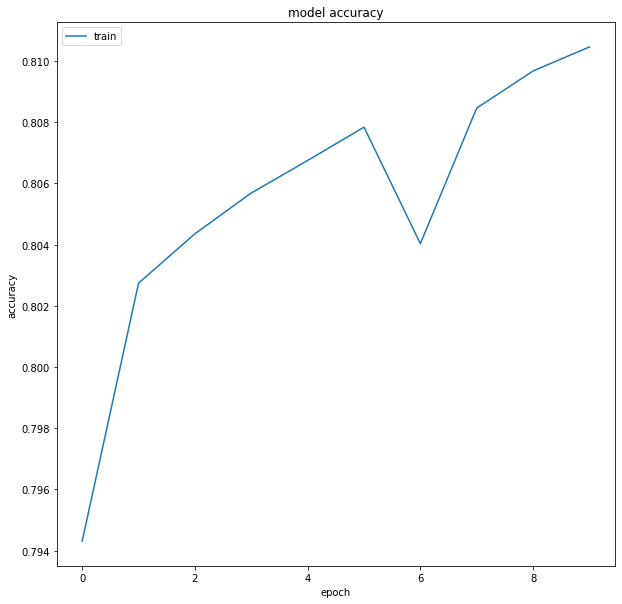

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

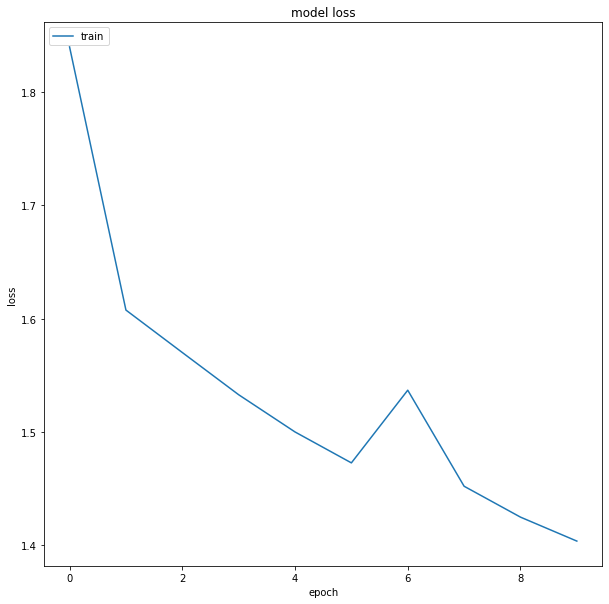

In [24]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
# dot_img_file = "d_mod-"+str(d_model)+"-d_k-"+str(d_k)+"-d_v-"+str(d_v)+"-n_heads-"+str(n_heads)+"-enc_lays-"+str(n_encoder_layers)+"-dec_lays-"+str(n_decoder_layers)+'-transformer.png'
# tf.keras.utils.plot_model(transformer, to_file=dot_img_file, show_shapes=True)

In [26]:
#transformer = keras.models.load_model('./Models/')

## Testing

In [27]:
def greedy_translate(model, source_sentence, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    predict_label = tf.argmax(predict_output, axis=-1) # Pick the label with highest softmax score
    predict_seq = tf.concat([predict_seq, predict_label], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label[0][0].numpy())
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False)
  return detokenize(predict_sentence, sp_ben_bpe)

In [28]:
import tensorflow_probability as tfp

In [29]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  কিন্তু, এই ঘটনায় আহত হয়েছেন।


In [30]:
sentence = "I am tired."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I am tired.
Bengali Sentence:  কিন্তু, এই ঘটনায় আহত হয়েছেন।


In [31]:
sentences = list(test_val_data['src'][:250])
refs = [list(test_val_data['tgt'][:250])]
sys = [greedy_translate(transformer, sentence) for sentence in sentences]

In [32]:
bleu = BLEU()
bleu.corpus_score(sys, refs)

BLEU = 0.06 9.1/0.2/0.1/0.0 (BP = 0.249 ratio = 0.419 hyp_len = 1500 ref_len = 3583)

In [33]:
chrf = CHRF()
chrf.corpus_score(sys, refs)

chrF2 = 5.04

In [34]:
ter = TER()
ter.corpus_score(sys, refs)

TER = 99.45

In [51]:
val_perf = pd.DataFrame({'src':sentences, 'sys':sys, 'ref':refs[0]})
val_perf

,src,sys,ref
0,"Through her work, she spread the message of th...","কিন্তু, এই ঘটনায় আহত হয়েছেন।",নিজের কর্মেরউদাহরণ স্থাপন করে তিনি মানুষকে সেব...
1,Interacting with beneficiaries and store owner...,"কিন্তু, এই ঘটনায় আহত হয়েছেন।",সারা দেশের ৫ হাজারেরও বেশি স্থান থেকে দোকান মা...
2,These include:,"কিন্তু, এই ঘটনায় আহত হয়েছেন।",এই প্রকল্পগুলির মধ্যে রয়েছে-
3,It is no surprise that today Japan is India’s ...,"কিন্তু, এই ঘটনায় আহত হয়েছেন।",জাপান যে বর্তমানে ভারতের চতুর্থ বৃহত্তম প্রত্য...
4,Record growth in last two and a half years,"কিন্তু, এই ঘটনায় আহত হয়েছেন।",গত আড়াই বছরেরেকর্ড পরিমাণ অগ্রগতি
...,...,...,...
245,•India will emerge as a global leader in trans...,"কিন্তু, এই ঘটনায় আহত হয়েছেন।",· সর্বাধুনিক প্রযুক্তি এবং দক্ষ শ্রমিকের ব্যবহ...
246,BHIM stands for Bharat Interface for Money.,"কিন্তু, এই ঘটনায় আহত হয়েছেন।",BHIM মানে ভারত ইন্টারফেস ফর মানি।
247,"Heartiest congratulations, Beti Shivangi.","কিন্তু, এই ঘটনায় আহত হয়েছেন।",কন্যা শিবাঙ্গীকে অনেক অনেক অভিনন্দন!
248,"But, we are now awaiting the rains.","কিন্তু, এই ঘটনায় আহত হয়েছেন।",বর্ষার প্রতীক্ষা চলছেই ।


In [35]:
def sampling_translate(model, source_sentence, temperature=0.6, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  logprob = 0
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    probs = predict_output[-1].numpy()[0]
    log_probs = np.log(probs)
    u = np.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
    g = -np.log(-np.log(u))
    sample_idx = np.argmax(log_probs + g * temperature, axis=-1)
    sample_prob = predict_output[-1].numpy()[0][sample_idx]
    logprob += np.log(sample_prob)
    predict_label = np.arange(predict_output.shape[-1])[sample_idx] # Sample the label softmax score
    predict_seq = tf.concat([predict_seq, tf.cast([[predict_label]], dtype=tf.int32)], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label)
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False), logprob
  return detokenize(predict_sentence, sp_ben_bpe), logprob

In [36]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", sampling_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  ('কিন্তু এ ছাড়া, আর কোনো কিছু নয়।', -27.09476343402639)


In [37]:
sentence = "I am hungry."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", sampling_translate(transformer, sentence))

English Sentence:  I am hungry.
Bengali Sentence:  ('তবে তিনি, তার পর,,, এই ধরনের প্রভাব রাখা উচিত।', -45.90712036844343)


In [38]:
def generate_samples(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = [], []
    for _ in range(n_samples):
        sample, logp = sampling_translate(model, sentence, temperature)
        samples.append(sample)
        log_probs.append(logp)
    return samples, log_probs

In [39]:
def rouge1_similarity(system, reference):
    sys_counter = Counter(system)
    ref_counter = Counter(reference)
    overlap = 0
    for token in sys_counter:
        token_count_sys = sys_counter[token]
        token_count_ref = ref_counter[token]
        overlap += min(token_count_ref, token_count_sys)
    precision = overlap / sum(sys_counter.values())
    recall = overlap / sum(ref_counter.values())
    if precision + recall != 0:
        rouge1_score = 2 * ((precision * recall)/(precision + recall))
    else:
        rouge1_score = 0     
    return rouge1_score

In [40]:
def weighted_avg_overlap(samples, log_probs):
    scores = {}
    for index_candidate, candidate in enumerate(samples):    
        overlap, weight_sum = 0.0, 0.0
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):           
            if index_candidate == index_sample:
                continue
            sample_p = float(np.exp(logp))
            weight_sum += sample_p
            sample_overlap = rouge1_similarity(candidate, sample)
            overlap += sample_p * sample_overlap
        score = overlap / weight_sum
        scores[index_candidate] = score
    return scores

In [41]:
def mbr_decode(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = generate_samples(sentence, n_samples, model, temperature)
    scores = weighted_avg_overlap(samples, log_probs)
    max_score_key = max(scores, key=scores.get)
    return Counter({sample:score for sample, score in zip(samples, scores.values())})

In [42]:
sentence = "I love you."
translated_sentence = mbr_decode(sentence, 2, transformer, 1)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I love you.
Bengali:  Counter({'কিন্তু অপরিবর্তিত থাকতে পেরেছিলেন ঠিক।': 0.5205479452054795, '১৩ ঈশ্বরের বাক্য বাইবেল\u200cমে জোর নেই।': 0.5205479452054795})


In [43]:
sentence = "How are you."
translated_sentence = mbr_decode(sentence, 2, transformer, 1)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  How are you.
Bengali:  Counter({'ও পাকিস্তানের প্রথম চেম্বার চৌধুরী বলেন, সেজ, এটি পদক্ষেপ নেওয়ার চেষ্টাতামূলক কাজ।': 0.6751592356687898, 'আপনারা আর যদি আর আমি প্রধানমন্ত্রীর কাজ করেছিলাম ছবিটির জনপ্রিয় হয়ে যাই।': 0.6751592356687898})


In [44]:
sentence = "How are you."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  How are you.
Bengali:  Counter({'তবে এই ঘটনায় আহত হয়েছেন।': 0.9162899026197523, 'এই ঘটনায় আহত হয়েছেন।': 0.8978649638336139, 'কিন্তু তার কথায়, ‘আমি বিয়ে করি।': 0.474128101382542, 'আমি তিনি যাব।': 0.4572266000853043, '"এই বিষয়ে এর সাথে এই রকম এক টাকা বেশি ধন্যবাদ বের করতে হবে।': 0.3911542736618792, 'কিন্তু এই সময় বাড়ি লাগার পর, ‘‘এ ভারত': 0.3620098330840634, 'তুমি আমার সাথে তিনি, খুব বেশি ভালো।': 0.35243264837063804, 'তিনি বলেন, ‘আমি আপনার দিকে থাকতে পারি, আমি জানি।': 0.3160844912352238, 'আমি এমন ঠিক আমার কাছে আমাদের চোখের সঙ্গে কাজ করি।': 0.31057013275355483, '(১:৯) এই কথাগুলো যিহোবার সাক্ষিরা আমাদের কাছে আমাদের প্রতি একটি এই কিছুর জন্য আমাদের প্রার্থনা করে।': 0.2982000408557965})


In [45]:
sentence = "I am hungry."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I am hungry.
Bengali:  Counter({'তার সঙ্গে, আমরা কী বলি?': 0.5023909900026999, 'আমাদের দিন থেমে যায়।': 0.48546375450234514, 'কিন্তু আমি কি আমাদের কাছে আনন্দ নাই?': 0.44787585644044026, 'তিনি বলেন, ‘আমি কিছু\u200c না।': 0.4446457153719674, 'তিনি বলেন, ‘আমি আমার জন্য কোনও ধরনের বিষয় নই।': 0.437442562218069, 'তার মধ্যে নরেন্দ্র মোদী, “সত্যির পর, ‘এই কিছু।': 0.4286514696791738, 'এই বিষয়টা কী আছে?': 0.4011575707214676, 'এ ঘটনায় দু’পক্ষের মামলা দায়ের করা হয়েছে।': 0.3955752540944655, 'কিন্তু তিনি সেই অনেক সফল হয়নি।': 0.3939850233895167, 'ফলে, তিনি তার সঙ্গে সবচেয়ে বেশি পরিবর্তন চলছে।': 0.3554617185785072})
